In [8]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.optimize import minimize

In [46]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'NFLX']
end_date = dt.datetime(2023, 1, 1); start_date = end_date - dt.timedelta(days=2*365)
stock = yf.download(tickers, start=start_date, end=end_date)
stock.head()

C:\Users\sayak\AppData\Local\Temp\ipykernel_21092\4037487588.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


Price            Close                                                \
Ticker            AAPL      GOOGL        MSFT        NFLX       NVDA   
Date                                                                   
2021-01-04  126.239693  85.791977  209.617172  522.859985  13.078193   
2021-01-05  127.800499  86.483833  209.819382  520.799988  13.368658   
2021-01-06  123.498520  85.630447  204.378922  500.489990  12.580535   
2021-01-07  127.712700  88.188118  210.194916  508.890015  13.308070   
2021-01-08  128.815018  89.355606  211.475601  510.399994  13.241001   

Price             High                                                ...  \
Ticker            AAPL      GOOGL        MSFT        NFLX       NVDA  ...   
Date                                                                  ...   
2021-01-04  130.336797  87.599132  214.730254  540.799988  13.615742  ...   
2021-01-05  128.512626  86.820809  210.416400  526.780029  13.407303  ...   
2021-01-06  127.839507  86.678665  208.461691  513.099976  13.209337  ...   
2021-01-07  128.405313  88.361077  211.205980  516.440002  13.341730  ...   
2021-01-08  129.380811  89.431650  212.400007  513.239990  13.384863  ...   

Price             Open                                                \
Ticker            AAPL      GOOGL        MSFT        NFLX       NVDA   
Date                                                                   
2021-01-04  130.249006  87.475378  214.277682  539.000000  13.068968   
2021-01-05  125.732440  85.740291  209.203116  521.549988  13.064479   
2021-01-06  124.591085  84.506193  204.301886  511.970001  13.186898   
2021-01-07  125.215418  85.823295  206.102523  508.279999  12.932584   
2021-01-08  129.185698  88.328267  210.570458  511.309998  13.326521   

Price          Volume                                          
Ticker           AAPL     GOOGL      MSFT     NFLX       NVDA  
Date                                                           
2021-01-04  143301900  37324000  37130100  4444400  560640000  
2021-01-05   97664900  20360000  23823000  3133900  322760000  
2021-01-06  155088000  46588000  35930700  5346200  580424000  
2021-01-07  109578200  41936000  27694500  3686400  461480000  
2021-01-08  105158200  35484000  22956200  2973900  292528000  

[5 rows x 25 columns]

(503, 5)


<Axes: xlabel='Date'>

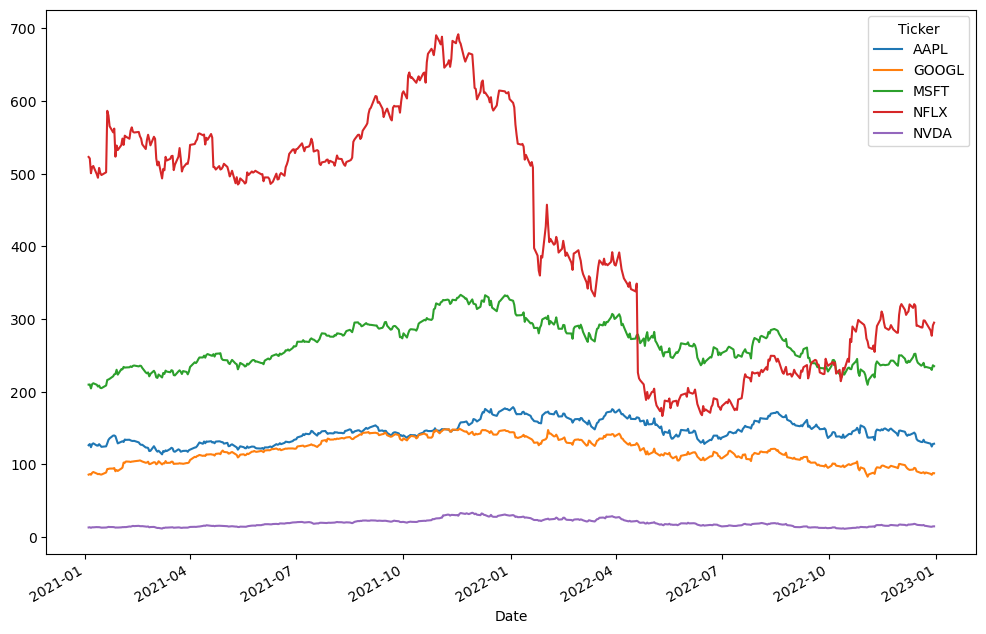

In [47]:
print(stock['Close'].shape)
stock['Close'].plot(figsize=(12, 8))

Text(0.5, 1.0, 'Normalized Returns of Selected Stocks')

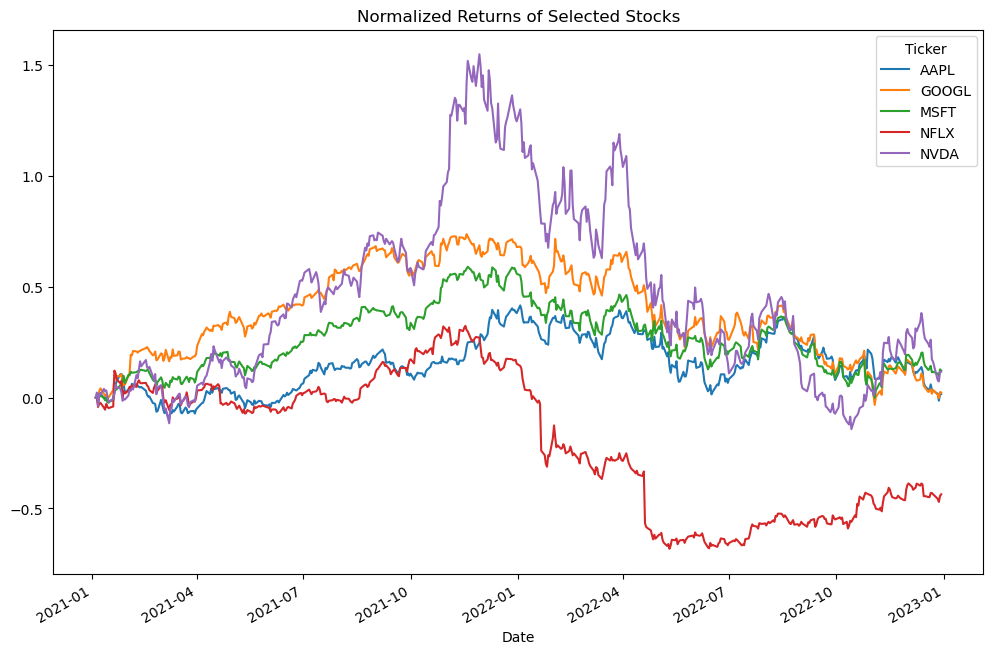

In [48]:
close_prices = stock['Close']
close_prices.head()
normalized_returns = close_prices/close_prices.iloc[0] - 1

normalized_returns.plot(figsize=(12, 8))
plt.title('Normalized Returns of Selected Stocks')

In [49]:
log_returns = np.log(close_prices/close_prices.shift(1))
log_returns.dropna(inplace=True)
log_returns.head()

Ticker,AAPL,GOOGL,MSFT,NFLX,NVDA
Date,,,,,
2021-01-05,0.012288,0.008032,0.000964,-0.003948,0.021967
2021-01-06,-0.034241,-0.009917,-0.026271,-0.039778,-0.060762
2021-01-07,0.033554,0.029431,0.028060,0.016644,0.056220
2021-01-08,0.008594,0.013152,0.006074,0.002963,-0.005052
2021-01-11,-0.023523,-0.023377,-0.009746,-0.022388,0.025635


Text(0.5, 1.0, 'Estimated Covariance Matrix of Yearly Returns')

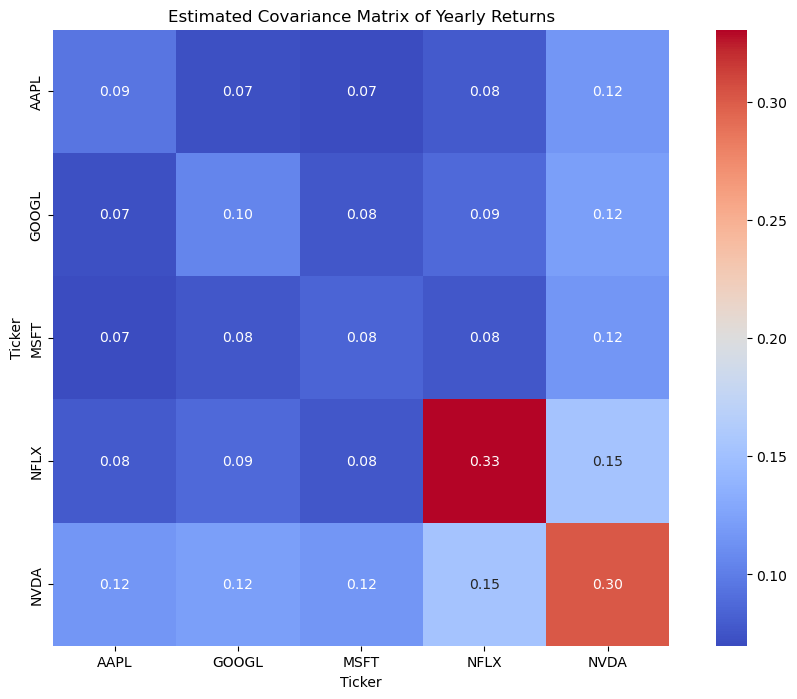

In [50]:
# estimated covariance amtrix of yearly returns
cov_mat = log_returns.cov() * 252
plt.figure(figsize=(12, 8))
sns.heatmap(cov_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Estimated Covariance Matrix of Yearly Returns')

In [51]:
n_assets = len(tickers)
initial_weights = np.array([1/n_assets]*n_assets)
print(initial_weights.shape)
print(log_returns.shape)
temp_res = np.dot(log_returns, initial_weights)
# print(temp_res.shape)

# print(temp_res[:5])

# print(log_returns.iloc[:5,:])

max_return_1 = log_returns.iloc[:251,:].sum(axis = 0).max()
max_return_2 = log_returns.iloc[251:,:].sum(axis = 0).max()


print(log_returns.iloc[:251,:].sum(axis = 0))
print(initial_weights)
print(np.dot(log_returns.iloc[:251,:].sum(axis = 0), initial_weights))


(5,)
(502, 5)
Ticker
AAPL     0.322525
GOOGL    0.517808
MSFT     0.443338
NFLX     0.141674
NVDA     0.808599
dtype: float64
[0.2 0.2 0.2 0.2 0.2]
0.44678900094063756


In [52]:
# optimized portfolio with high risk

# number of assets:
n_assets = len(tickers)
# initial guess for weights (equal distribution)
initial_weights = np.array([1/n_assets]*n_assets)

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: 1 - np.max(weights)},
    {'type': 'ineq', 'fun': lambda weights: np.min(weights)},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns.iloc[:251,:].sum(axis = 0), weights) - max_return_1*0.8},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns.iloc[251:,:].sum(axis = 0), weights) - max_return_2*0.8}
)

def portfolio_volatility(weights):
    portfolio_var = np.dot(weights.T, np.dot(cov_mat, weights))
    return portfolio_var

result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

print(np.sqrt(result.fun))

0.4287158974636689


In [53]:
# optimized portfolio with high risk

# number of assets:
n_assets = len(tickers)
# initial guess for weights (equal distribution)
initial_weights = np.array([1/n_assets]*n_assets)

constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: 1 - np.max(weights)},
    {'type': 'ineq', 'fun': lambda weights: np.min(weights)},
    {'type': 'ineq', 'fun': lambda weights: np.dot(log_returns.sum(axis = 0), weights)}
)

def portfolio_volatility(weights):
    portfolio_var = np.dot(weights.T, np.dot(cov_mat, weights))
    return portfolio_var

result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

print(np.sqrt(result.fun))

0.28054873303322875


In [60]:
end_date = dt.datetime(2024, 12, 31); start_date = end_date - dt.timedelta(days=365)
stock_2024 = yf.download(tickers, start=start_date, end=end_date)
stock_2024['Close'].head()

log_returns_2024 = np.log(stock_2024['Close']/stock_2024['Close'].shift(1))
log_returns_2024.dropna(inplace = True)
log_returns_2024.head()

C:\Users\sayak\AppData\Local\Temp\ipykernel_21092\640392381.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_2024 = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,GOOGL,MSFT,NFLX,NVDA
Date,,,,,
2024-01-03,-0.007516,0.005413,-0.000728,0.003750,-0.012514
2024-01-04,-0.012782,-0.018380,-0.007204,0.009334,0.008978
2024-01-05,-0.004021,-0.004851,-0.000516,-0.001286,0.022639
2024-01-08,0.023887,0.022654,0.018696,0.022877,0.062299
2024-01-09,-0.002266,0.015083,0.002931,-0.006080,0.016833
